# Street sign with Pre-Trained WideResNet

With additional shield net 

In [1]:
from torch.utils.data import Dataset, DataLoader
from os.path import join
import pandas as pd 
from PIL import Image
from torch.optim import SGD
import seaborn as sb 
from gtsrb import GTSRB
from detectors import EnsembleDetector, SemanticDetector
import os 
from pytorch_ood.utils import fix_random_seed
import seaborn as sb 
import torch 

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-GPU-ff380879-d5b2-8469-da3d-71267d28a645/0/0" 

sb.set()

device="cuda:0"
root = "data/"


fix_random_seed()

def seed_worker(worker_id):
    fix_random_seed()

g = torch.Generator()
g.manual_seed(0)


In [2]:
import torchvision
from torchvision.transforms import ToTensor, Resize, Compose
import torch 
from torch.utils.data import DataLoader

trans = Compose([ToTensor(), Resize((32, 32))])

train_data = GTSRB(root=root, train=True, transforms=trans)
test_data = GTSRB(root=root, train=False, transforms=trans)

In [3]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)

In [4]:
from torch import nn
from torchvision.models.resnet import resnet18
from pytorch_ood.model import WideResNet
from functools import partial

def myfeatures(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    return x
    
# def override 
def Model(num_classes=None, *args, **kwargs):
    model = resnet18(num_classes=num_classes)
    model.myfeatures = partial(myfeatures, model)
#     model = WideResNet(*args, num_classes=1000, **kwargs, pretrained="imagenet32")
#     model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [5]:
from tqdm.notebook import tqdm 
import numpy as np 

def train_model(att_index, num_classes):
    """
    train a model for the given attribute index 
    """
    trans = Compose([ToTensor(), Resize((32, 32))])
    train_data = GTSRB(root=root, train=True, transforms=trans)
    test_data = GTSRB(root=root, train=False, transforms=trans)
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)
    
    model = Model(num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    accs = []

    for epoch in range(20):
        running_loss = 0.0
        model.train()
        bar = tqdm(train_loader)
        for inputs, y in bar:
            labels = y[:, att_index]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in test_loader:
                labels = y[:, att_index]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the test images: {correct / total:.2%}')

    return model 

# Sign Network 

In [6]:
from torch.utils.data import DataLoader
from pytorch_ood.utils import is_known
from tqdm.notebook import tqdm 
from pytorch_ood.dataset.img import TinyImages300k
from pytorch_ood.utils import ToUnknown
from torch.utils.data import random_split

def train_sign_model():
    tiny = TinyImages300k(root=root, download=True, transform=trans, target_transform=ToUnknown())
    data_train_out, data_test_out, _ = random_split(tiny, [50000, 10000, 240000], generator=torch.Generator().manual_seed(123))

    train_data_noatt = GTSRB(root=root, train=True, transforms=trans, target_transform=lambda y: y[0])
    test_data_noatt = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])

    new_loader = DataLoader(train_data_noatt + data_train_out, batch_size=32, shuffle=True, num_workers=10, worker_init_fn=seed_worker)
    new_test_loader = DataLoader(test_data_noatt + data_test_out, batch_size=32, shuffle=False, num_workers=10, worker_init_fn=seed_worker)

    model = Model(num_classes=2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    accs = []

    for epoch in range(20):
        running_loss = 0.0
        model.train()
        
        bar = tqdm(new_loader)
        for inputs, y in bar:
            labels = is_known(y).long()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in new_test_loader:
                labels = is_known(y).long()
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the shape network on the test images: {correct / total:.2%}')
        accs.append(correct / total)

    return model 

# OOD Evaluation 

In [7]:
from pytorch_ood.dataset.img import (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)
from pytorch_ood.detector import EnergyBased, MaxSoftmax, Mahalanobis, MaxLogit, ViM, Entropy
from pytorch_ood.utils import ToRGB, OODMetrics


def evaluate(label_net, shape_net, color_net, shield_net):
    _ = label_net.eval()
    _ = shape_net.eval()
    _ = color_net.eval()
    _ = shield_net.eval()
    
    results = []

    trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
    data_in_train = GTSRB(root=root, train=True, transforms=trans, target_transform=lambda y: y[0])
    loader_train = DataLoader(data_in_train, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
    # dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
    
    detectors = {
        "MSP": MaxSoftmax(label_net),
        "Energy": EnergyBased(label_net),
        "Mahalanobis": Mahalanobis(label_net.myfeatures),
        "MaxLogit": MaxLogit(label_net),
        "Entropy": Entropy(label_net),
        "ViM": ViM(label_net.myfeatures, w=label_net.fc.weight, b=label_net.fc.bias, d=64),
        "Semantic-OE": SemanticDetector(
            label_net, 
            shape_net, 
            color_net, 
            GTSRB(root=root).class_to_shape, 
            GTSRB(root=root).class_to_color, 
            sign_net=shield_net
        ),
        "Semantic": SemanticDetector(
                label_net, 
                shape_net, 
                color_net, 
                GTSRB(root=root).class_to_shape, 
                GTSRB(root=root).class_to_color, 
        ),
        "Ensemble": EnsembleDetector(label_net, shape_net, color_net)
    }
    
    for detector_name, detector in detectors.items():
        print(f"Fitting {detector_name}")
        try:
            detector.fit(loader_train, device=device)
        except TypeError:
            detector.fit(loader_train)
        
    datasets = {d.__name__: d for d in (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)}
    
    for detector_name, detector in detectors.items():
        for data_name, dataset_c in datasets.items():
            data_out = dataset_c(root=root, transform=trans, target_transform=ToUnknown(), download=True)
            loader = DataLoader(data_in+data_out, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
            scores = []
            ys = []
            
            with torch.no_grad():
                for x, y in loader:
                    scores.append(detector(x.to(device)))
                    ys.append(y.to(device))
                    
                scores = torch.cat(scores, dim=0).cpu()
                ys = torch.cat(ys, dim=0).cpu()
            
            metrics = OODMetrics()
            metrics.update(scores, ys)
            r = metrics.compute()
            r.update({
                "Method": detector_name,
                "Dataset": data_name
            })
            print(r)
            results.append(r)
    
    return results 

In [8]:
def evaluate_acc(net, att_idx=0, oe=False):
    _ = net.eval()
    
    if oe:
        target_trans = lambda y: torch.tensor(1)
    else:
         target_trans = lambda y: y[att_idx]

    trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=target_trans)
    loader = DataLoader(data_in, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            predicted = outputs.max(dim=1).indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total  

def evaluate_accs(label_net, shape_net, color_net, shield_net):
    r = {}
    names = ("Label", "Color", "Shape",)
    
    for n, net in enumerate((label_net, color_net, shape_net)): 
        acc = evaluate_acc(net, n)
        r[names[n]] = acc
    
    acc = evaluate_acc(shield_net, oe=True)
    r["Sign"] = acc
    
    return [r] 

In [ ]:
results = []
results_acc = []

for trial in range(10):
    shield_net = train_sign_model()
    shape_net = train_model(att_index=2, num_classes=5)
    color_net = train_model(att_index=1, num_classes=4)
    label_net = train_model(att_index=0, num_classes=43)
    
    res = evaluate(label_net, shape_net, color_net, shield_net)
    res_acc = evaluate_accs(label_net, shape_net, color_net, shield_net)
    
    for r in res:
        r.update({"Seed": trial})
        
    for r in res_acc:
        r.update({"Seed": trial})
    
    results += res
    results_acc += res_acc

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 97.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 97.54%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.50%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.06%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.54%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.90%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.75%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.85%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.73%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.94%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.29%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.19%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.59%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.05%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.91%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.68%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.92%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.22%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.66%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.05%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.08%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.36%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.52%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.49%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.33%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.52%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.56%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.21%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.34%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.41%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.45%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.48%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.45%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.46%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.52%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.30%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.45%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.48%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.41%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.02%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.15%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.27%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.26%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.21%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.23%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.32%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.08%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.10%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.36%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.20%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.29%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.40%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.39%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.32%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.19%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.34%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 78.39%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 84.57%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 87.05%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 88.65%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.13%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.56%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.48%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.10%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.45%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.74%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.57%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.77%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.02%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.59%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.67%
Fitting MSP
Fitting Energy
Fitting Mahalanobis
Fitting MaxLogit
Fitting Entropy
Fitting ViM
Fitting Semantic-OE
Fitting Semantic
Fitting Ensemble
{'AUROC': 0.9063628315925598, 'AUPR-IN': 0.8455926775932312, 'AUPR-OUT': 0.9391732811927795, 'FPR95TPR': 0.2615201771259308, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9137046337127686, 'AUPR-IN': 0.8623936176300049, 'AUPR-OUT': 0.9430437088012695, 'FPR95TPR': 0.258511483669281, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9202264547348022, 'AUPR-IN': 0.7945129871368408, 'AUPR-OUT': 0.9673150777816772, 'FPR95TPR': 0.23333333432674408, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9025712609291077, 'AUPR-IN': 0.8471947908401489, 'AUPR-OUT': 0.9341633915901184, 'FPR95TPR': 0.2892319858074188, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.9105852246284485, 'AUPR-IN': 0.8568270206451416, 'AUPR-OUT': 0.9408645033836365, 'FPR95TPR': 0.26278701424598694, 'Method

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.21%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.84%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.75%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.57%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.39%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.80%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.82%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.15%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.94%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.88%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.10%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.80%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.83%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.03%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.16%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.16%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.94%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.73%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.26%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.56%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.61%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.40%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.42%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.64%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.52%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.56%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.50%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.57%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.39%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.49%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.53%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.54%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.51%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.56%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 96.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.40%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.07%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.14%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.22%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.21%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.28%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.24%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.20%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.22%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.24%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.24%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.26%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.84%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.32%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.10%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.28%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 78.16%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 85.53%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 87.40%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 88.69%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 88.50%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.19%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.56%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.52%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.26%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.55%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.51%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.08%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.01%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.24%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.03%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.25%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.48%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 91.68%
Fitting MSP
Fitting Energy
Fitting Mahalanobis
Fitting MaxLogit
Fitting Entropy
Fitting ViM
Fitting Semantic-OE
Fitting Semantic
Fitting Ensemble
{'AUROC': 0.9234938621520996, 'AUPR-IN': 0.8718752264976501, 'AUPR-OUT': 0.9519460201263428, 'FPR95TPR': 0.21108472347259521, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9208537340164185, 'AUPR-IN': 0.8708376884460449, 'AUPR-OUT': 0.9492807984352112, 'FPR95TPR': 0.22525732219219208, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9320485591888428, 'AUPR-IN': 0.8236138820648193, 'AUPR-OUT': 0.9726036190986633, 'FPR95TPR': 0.20435471832752228, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9198192358016968, 'AUPR-IN': 0.8696720004081726, 'AUPR-OUT': 0.9481627941131592, 'FPR95TPR': 0.23618368804454803, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.9166458249092102, 'AUPR-IN': 0.8673052191734314, 'AUPR-OUT': 0.9455640316009521, 'FPR95TPR': 0.2463182955980301, 'Met

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 96.83%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.78%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.46%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.58%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.62%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.11%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.02%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.07%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.21%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.25%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.19%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 98.70%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.27%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.32%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.21%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.12%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.26%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.05%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.31%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.32%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.43%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.44%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.38%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.44%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.38%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.55%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.42%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.41%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.44%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.38%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.37%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.61%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.55%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.38%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.83%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.21%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.14%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.04%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.22%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.13%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.28%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.24%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.25%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.25%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.12%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.17%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.27%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.13%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.33%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.12%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 80.20%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 85.32%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 88.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 88.11%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 88.27%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.83%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.36%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.29%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 89.49%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.22%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 90.53%


  0%|          | 0/1226 [00:00<?, ?it/s]

In [31]:
import pandas as pd 
result_df = pd.DataFrame(results)
tab = (result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].sort_values(by=("AUROC", "mean"))
string = tab.to_latex(float_format="%.2f").replace("& 0", "& $\pm$ 0").replace("& 1", "& $\pm$ 1")
print(string)

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95TPR} \\
{} &  mean &  sem &    mean &  sem &     mean &  sem &     mean &  sem \\
Method      &       &      &         &      &          &      &          &      \\
\midrule
MSP         & 91.97 & $\pm$ 0.12 &   85.46 & $\pm$ 0.43 &    95.14 & $\pm$ 0.15 &    23.36 & $\pm$ 0.33 \\
Entropy     & 92.94 & $\pm$ 0.12 &   87.94 & $\pm$ 0.36 &    95.57 & $\pm$ 0.14 &    22.90 & $\pm$ 0.33 \\
Mahalanobis & 94.29 & $\pm$ 0.28 &   87.59 & $\pm$ 1.08 &    96.86 & $\pm$ 0.09 &    16.54 & $\pm$ 0.55 \\
MaxLogit    & 95.00 & $\pm$ 0.11 &   91.00 & $\pm$ 0.29 &    96.82 & $\pm$ 0.12 &    17.40 & $\pm$ 0.36 \\
Energy      & 95.13 & $\pm$ 0.12 &   91.26 & $\pm$ 0.29 &    96.89 & $\pm$ 0.12 &    17.16 & $\pm$ 0.37 \\
Ensemble    & 95.65 & $\pm$ 0.06 &   92.49 & $\pm$ 0.27 &    97.39 & $\pm$ 0.07 &    14.68 & $\pm$ 0.15 \\
ViM         & 96.36 & $\pm$ 0.

/tmp/ipykernel_242993/2484517756.py:3: FutureWarning: ['Dataset'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  tab = (result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].sort_values(by=("AUROC", "mean"))
/tmp/ipykernel_242993/2484517756.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string = tab.to_latex(float_format="%.2f").replace("& 0", "& $\pm$ 0").replace("& 1", "& $\pm$ 1")


In [32]:
(result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"])

/tmp/ipykernel_242993/735313046.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"])


AUROC              AUPR-IN             AUPR-OUT            \
                  mean       sem       mean       sem       mean       sem   
Method                                                                       
Energy       95.129521  0.163647  91.258708  0.325379  96.885163  0.116374   
Ensemble     95.653160  0.066219  92.485734  0.160560  97.388096  0.037088   
Entropy      92.939660  0.141743  87.940920  0.228606  95.574477  0.104541   
MSP          91.970790  0.156520  85.459458  0.250702  95.143767  0.110586   
Mahalanobis  94.289586  0.328545  87.585599  0.714103  96.862774  0.180864   
MaxLogit     95.000416  0.156360  90.997111  0.308625  96.815250  0.112669   
Semantic     97.386348  0.044632  96.028718  0.079701  98.399898  0.025333   
Semantic-OE  98.557652  0.068208  97.984105  0.091221  99.398617  0.028332   
ViM          96.363464  0.195796  92.555783  0.386638  97.876654  0.116577   

              FPR95TPR            
                  mean       sem  
Method                            
Energy       17.163579  0.526674  
Ensemble     14.675059  0.220041  
Entropy      22.902455  0.498141  
MSP          23.361837  0.508695  
Mahalanobis  16.535709  0.731083  
MaxLogit     17.404909  0.515221  
Semantic     11.577197  0.214539  
Semantic-OE   2.866983  0.136804  
ViM          12.201267  0.537586

In [33]:
from scipy.stats import ttest_ind

for metric in ["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]:
    sem_auroc = np.array(result_df[result_df["Method"] == "Semantic"].groupby(by=["Method", "Seed"]).mean(numeric_only=True)[metric])
    sem_ensemble =  np.array(result_df[result_df["Method"] == "Ensemble"].groupby(by=["Method", "Seed"]).mean(numeric_only=True)[metric])
    stat, p = ttest_ind(sem_auroc, sem_ensemble, equal_var=False) # , permutations=100000
    print(f"Metric: {metric} -> {p}")

Metric: AUROC -> 3.5715444796347597e-13
Metric: AUPR-IN -> 3.5036909178797056e-11
Metric: AUPR-OUT -> 1.7318364946700267e-13
Metric: FPR95TPR -> 7.945457912798345e-09


In [34]:
# dataset gives np.array([label, color, shape])
print((pd.DataFrame(results_acc) * 100).agg(["mean", "sem"]).to_latex(float_format="%.2f"))
# results_acc = evaluate_accs(label_net, shape_net, color_net, shield_net)
# print(results_acc)

\begin{tabular}{lrrrrr}
\toprule
{} &  Label &  Color &  Shape &  Sign &   Seed \\
\midrule
mean &  91.05 &  99.23 &  99.41 & 98.54 & 450.00 \\
sem  &   0.22 &   0.03 &   0.04 &  0.12 &  95.74 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_242993/1010695945.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((pd.DataFrame(results_acc) * 100).agg(["mean", "sem"]).to_latex(float_format="%.2f"))


# Eval

In [47]:
msp = MaxSoftmax(label_net)
semantic_detector = SemanticDetector(
                label_net, 
                shape_net, 
                color_net, 
                GTSRB(root=root).class_to_shape, 
                GTSRB(root=root).class_to_color)

In [61]:
from pytorch_ood.utils import TensorBuffer

data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
data_out = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)

loader = DataLoader(data_in + data_out, shuffle=False, batch_size=1024)

buffer = TensorBuffer()

for x, y in loader:
    scores_msp = msp(x.to(device))
    buffer.append("msp", scores_msp)
    
    scores_sem = semantic_detector(x.to(device))
    buffer.append("sem", scores_sem)
    
    buffer.append("y", y)

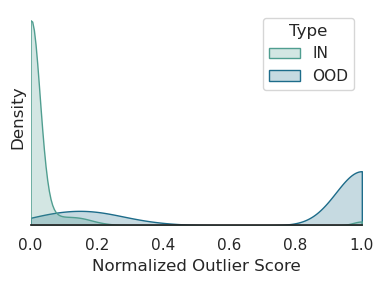

In [84]:
import matplotlib.pyplot as plt 
sb.set_style("white")

df = pd.DataFrame({"Scores": buffer["sem"].numpy() + 1, "label": buffer["y"]})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(4,3))

sb.kdeplot(data=df, x="Scores", clip=[0,1], common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.2) # , palette="crest" # , 
sb.move_legend(ax, "upper right")
plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True)
plt.xlim([0,1])
plt.yticks([])
plt.tight_layout()
plt.savefig("img/scores-gtsrb.pdf", bbox_inches="tight")

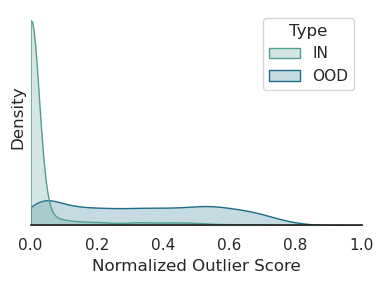

In [82]:
sb.set_style("white")

df = pd.DataFrame({"Scores": buffer["msp"].numpy() + 1, "label": buffer["y"]})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(4,3))

sb.kdeplot(data=df, x="Scores", clip=[0,1], common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.2) # , palette="crest" # , 
plt.xlim([0,1])
sb.move_legend(ax, "upper right")
plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True)

plt.yticks([])
plt.tight_layout()